# 5. Pancreas dataset integration with scVI/scANVI/BBKNN

Low-dimensional integration will be compared with scVI and scANVI


Referenced pages.

https://www.sc-best-practices.org/preamble.html

https://satijalab.org/seurat/articles/integration_mapping

In [ ]:
!pip install --quiet scanpy
!pip install --quiet 'scanpy[leiden]'
!pip install --quiet louvain
!pip install --quiet scvi-colab
from scvi_colab import install
install()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import tempfile
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/src')
import utils as my_u
from utils import data_transformation
from utils import clustering
from utils import h5_data_loader
import anndata as ad
import scanpy as sc
import logging
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
import umap
import scvi
import torch

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
datasets = ['/content/drive/MyDrive/Colab Notebooks/dataset/baron_sc.h5', '/content/drive/MyDrive/Colab Notebooks/dataset/muraro_sc.h5', '/content/drive/MyDrive/Colab Notebooks/dataset/segerstolpe_sc.h5', '/content/drive/MyDrive/Colab Notebooks/dataset/wang_sc.h5', '/content/drive/MyDrive/Colab Notebooks/dataset/xin_sc.h5']
label_filter = ['epsilon', 'alpha', 'beta', 'duct', 'activated', 'schwann', 'gamma', 'quiescent', 'delta', 'macrophage', 'endothelial', 'acinar', 'mast']


## scVI with Total->Log preprocessing

scVI integration work

In [ ]:
X_, y_, b_, file_names = h5_data_loader(datasets, label_filter)
logging.info(f'Data loaded. {datasets}')

adata = ad.AnnData(X_, dtype=np.int32)
adata.obs["label"] = y_
adata.obs["batch"] = b_
batch_key = "batch"
label_key = "label"
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#999999",
    "#ff00ff",
]  # Set custom colours for batches

sc.pp.filter_genes(adata, min_cells=2)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
sc.tl.pca(adata)
#sc.pp.neighbors(adata)

In [ ]:
adata_scvi = adata.copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 12927 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15590 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    baron_sc    │          0          │
│                    │   muraro_sc    │          1          │
│                    │ segerstolpe_sc │          2          │
│                    │    wang_sc     │          3          │
│                    │     xin_sc     │          4          │
└────────────────────┴────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
model_scvi.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:46<00:00,  1.51s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.19e+4]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:46<00:00,  1.62s/it, v_num=1, train_loss_step=1.31e+4, train_loss_epoch=1.19e+4]


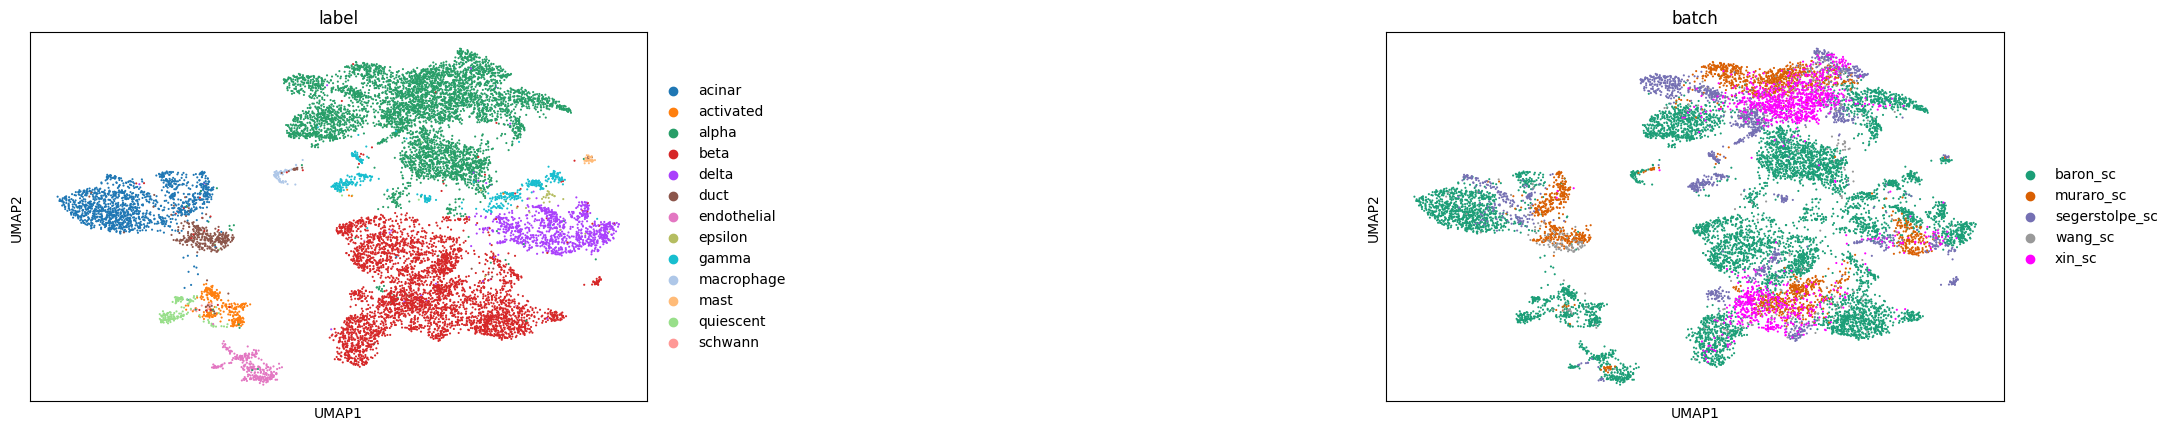

In [ ]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

In [ ]:
sc.pp.neighbors(adata_scvi, use_rep='X_scVI', key_added = "scvi_nn")

true = adata.obs["label"]
best = (0,0,0,0)
for res in np.arange(0.1, 3.01, 0.1):
    sc.tl.louvain(adata_scvi, obsp='scvi_nn_distances', resolution = res, key_added = "louvain_scvi_"+str(res))
    pred = adata_scvi.obs['louvain_scvi_'+str(res)]
    nmi = normalized_mutual_info_score(pred, true, average_method="arithmetic")
    label_ari = adjusted_rand_score(pred, y_)
    batch_ari = adjusted_rand_score(pred, b_)
    if best[1] < nmi:
        best = (res, nmi, batch_ari, label_ari)
print(best)

(0.1, 0.8484036108793291, -0.01931710040087526, 0.9204421528807389)


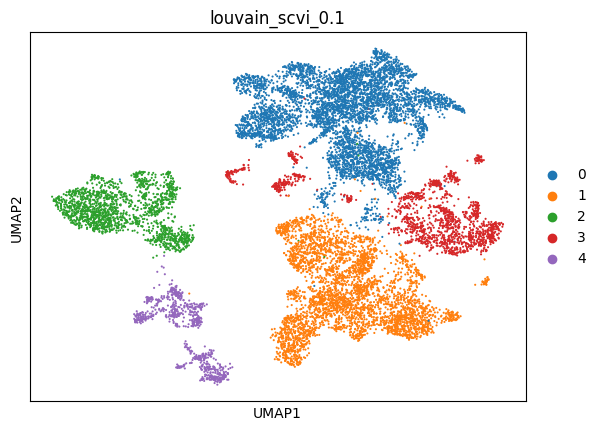

In [ ]:
sc.tl.umap(adata_scvi)
sc.pl.umap(adata_scvi, color=['louvain_scvi_0.1'])

## scVI with Total preprocessing

In [4]:
X_, y_, b_, file_names = h5_data_loader(datasets, label_filter)
logging.info(f'Data loaded. {datasets}')

adata = ad.AnnData(X_, dtype=np.int32)
adata.obs["label"] = y_
adata.obs["batch"] = b_
batch_key = "batch"
label_key = "label"
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#999999",
    "#ff00ff",
]  # Set custom colours for batches

sc.pp.filter_genes(adata, min_cells=2)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
sc.tl.pca(adata)
#sc.pp.neighbors(adata)

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 12927 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15590 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    baron_sc    │          0          │
│                    │   muraro_sc    │          1          │
│                    │ segerstolpe_sc │          2          │
│                    │    wang_sc     │          3          │
│                    │     xin_sc     │          4          │
└────────────────────┴────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [11:06<00:00,  1.67s/it, v_num=1, train_loss_step=1.18e+4, train_loss_epoch=1.19e+4]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [11:07<00:00,  1.67s/it, v_num=1, train_loss_step=1.18e+4, train_loss_epoch=1.19e+4]


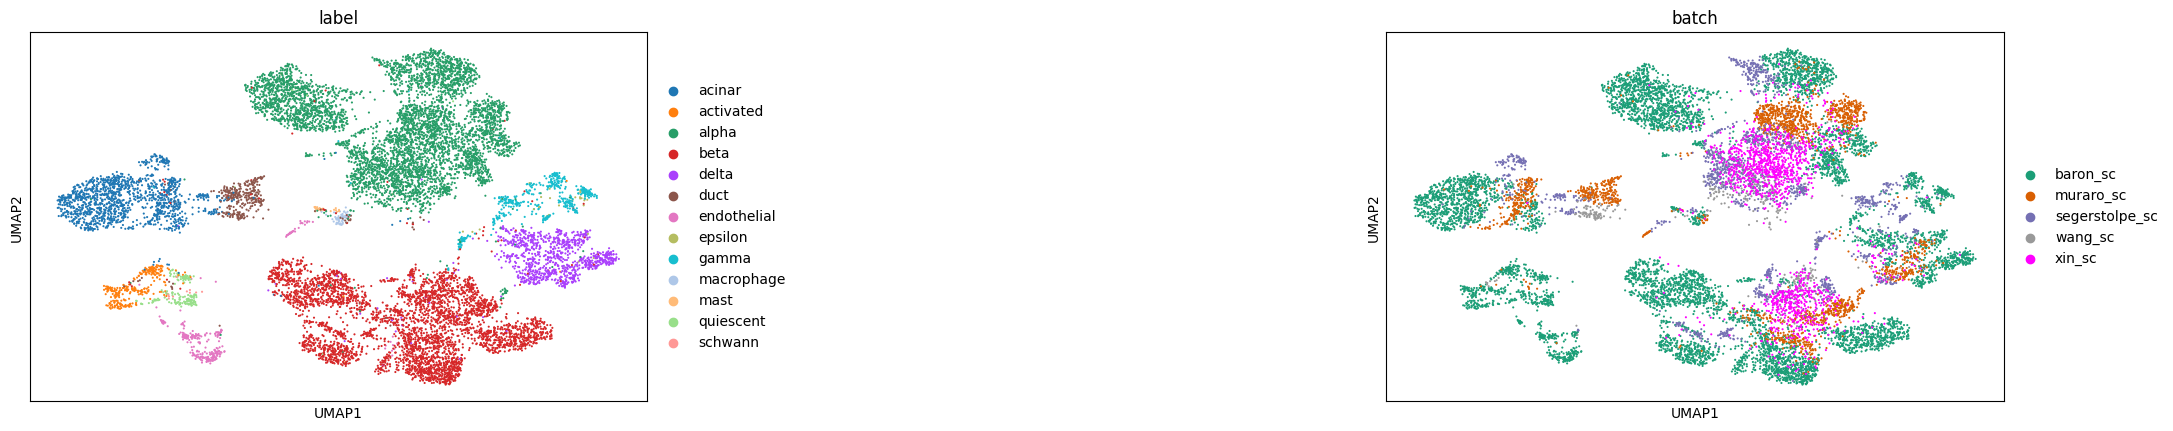

In [5]:
adata_scvi = adata.copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi.view_anndata_setup()
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
model_scvi.train()
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

In [6]:
sc.pp.neighbors(adata_scvi, use_rep='X_scVI', key_added = "scvi_nn")

true = adata.obs["label"]
best = (0,0,0,0)
for res in np.arange(0.1, 3.01, 0.1):
    sc.tl.louvain(adata_scvi, obsp='scvi_nn_distances', resolution = res, key_added = "louvain_scvi_"+str(res))
    pred = adata_scvi.obs['louvain_scvi_'+str(res)]
    nmi = normalized_mutual_info_score(pred, true, average_method="arithmetic")
    label_ari = adjusted_rand_score(pred, y_)
    batch_ari = adjusted_rand_score(pred, b_)
    if best[1] < nmi:
        best = (res, nmi, batch_ari, label_ari)
print(best)

(0.2, 0.7730430280704942, 0.008026806741679389, 0.616263135347095)


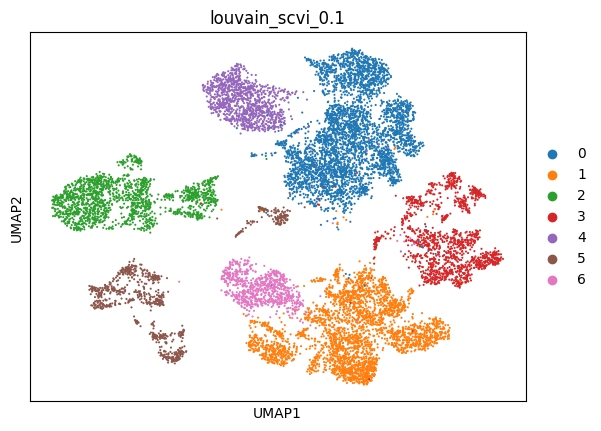

In [7]:
sc.tl.umap(adata_scvi)
sc.pl.umap(adata_scvi, color=['louvain_scvi_0.1'])

## scVI with raw data

In [4]:
X_, y_, b_, file_names = h5_data_loader(datasets, label_filter)
logging.info(f'Data loaded. {datasets}')

adata = ad.AnnData(X_, dtype=np.int32)
adata.obs["label"] = y_
adata.obs["batch"] = b_
batch_key = "batch"
label_key = "label"
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#999999",
    "#ff00ff",
]  # Set custom colours for batches

sc.pp.filter_genes(adata, min_cells=2)
adata.layers["counts"] = adata.X.copy()
#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
sc.tl.pca(adata)
#sc.pp.neighbors(adata)

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 12927 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15590 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    baron_sc    │          0          │
│                    │   muraro_sc    │          1          │
│                    │ segerstolpe_sc │          2          │
│                    │    wang_sc     │          3          │
│                    │     xin_sc     │          4          │
└────────────────────┴────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:44<00:00,  1.59s/it, v_num=1, train_loss_step=1.1e+4, train_loss_epoch=1.18e+4] 

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:44<00:00,  1.61s/it, v_num=1, train_loss_step=1.1e+4, train_loss_epoch=1.18e+4]


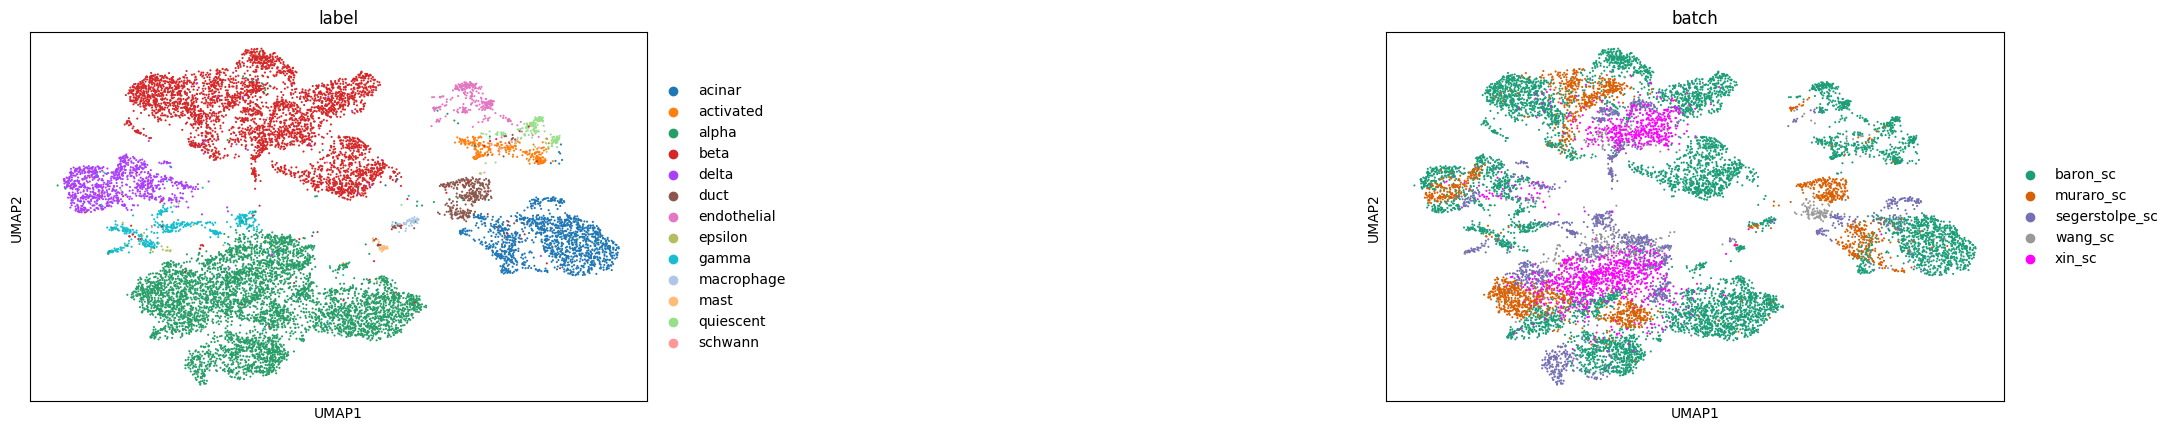

In [5]:
adata_scvi = adata.copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi.view_anndata_setup()
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
model_scvi.train()
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

In [6]:
sc.pp.neighbors(adata_scvi, use_rep='X_scVI', key_added = "scvi_nn")

true = adata.obs["label"]
best = (0,0,0,0)
for res in np.arange(0.1, 3.01, 0.1):
    sc.tl.louvain(adata_scvi, obsp='scvi_nn_distances', resolution = res, key_added = "louvain_scvi_"+str(res))
    pred = adata_scvi.obs['louvain_scvi_'+str(res)]
    nmi = normalized_mutual_info_score(pred, true, average_method="arithmetic")
    label_ari = adjusted_rand_score(pred, y_)
    batch_ari = adjusted_rand_score(pred, b_)
    if best[1] < nmi:
        best = (res, nmi, batch_ari, label_ari)
print(best)

(0.1, 0.7470742452907168, -0.03283466027592697, 0.653151410586291)


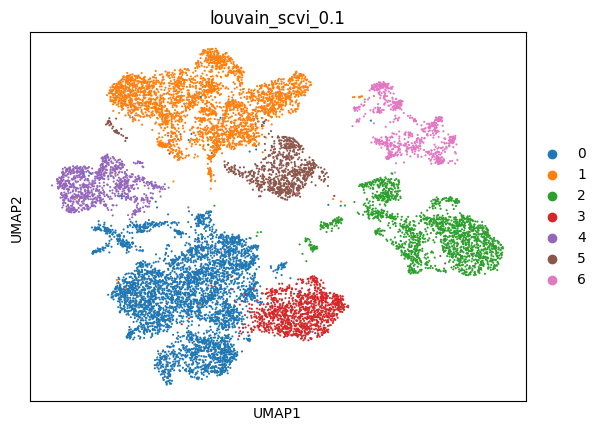

In [7]:
sc.tl.umap(adata_scvi)
sc.pl.umap(adata_scvi, color=['louvain_scvi_0.1'])

## scANVI with Total->Log preprocessing

In [ ]:
|model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key=label_key, unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()


ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'label',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 12927 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  14   │
│          n_vars          │ 15590 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    baron_sc    │          0          │
│                    │   muraro_sc    │          1          │
│                    │ segerstolpe_sc │          2          │
│                    │    wang_sc     │          3          │
│                    │     xin_sc     │          4          │
└────────────────────┴────────────────┴─────────────────────┘

                  labels State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['label'] │   acinar    │          0          │
│                    │  activated  │          1          │
│                    │    alpha    │          2          │
│                    │    beta     │          3          │
│                    │    delta    │          4          │
│                    │    duct     │          5          │
│                    │ endothelial │          6          │
│                    │   epsilon   │          7          │
│                    │    gamma    │          8          │
│                    │ macrophage  │          9          │
│                    │    mast     │         10          │
│                    │  quiescent  │         11          │
│                    │   schwann   │         12          │
│                    │ unlabelled  │         13          │
└────────────────────┴─────────────┴─────────────────────┘

In [ ]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)


INFO     Training for 10 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:50<00:00,  4.62s/it, v_num=1, train_loss_step=9.78e+3, train_loss_epoch=1.2e+4]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it, v_num=1, train_loss_step=9.78e+3, train_loss_epoch=1.2e+4]


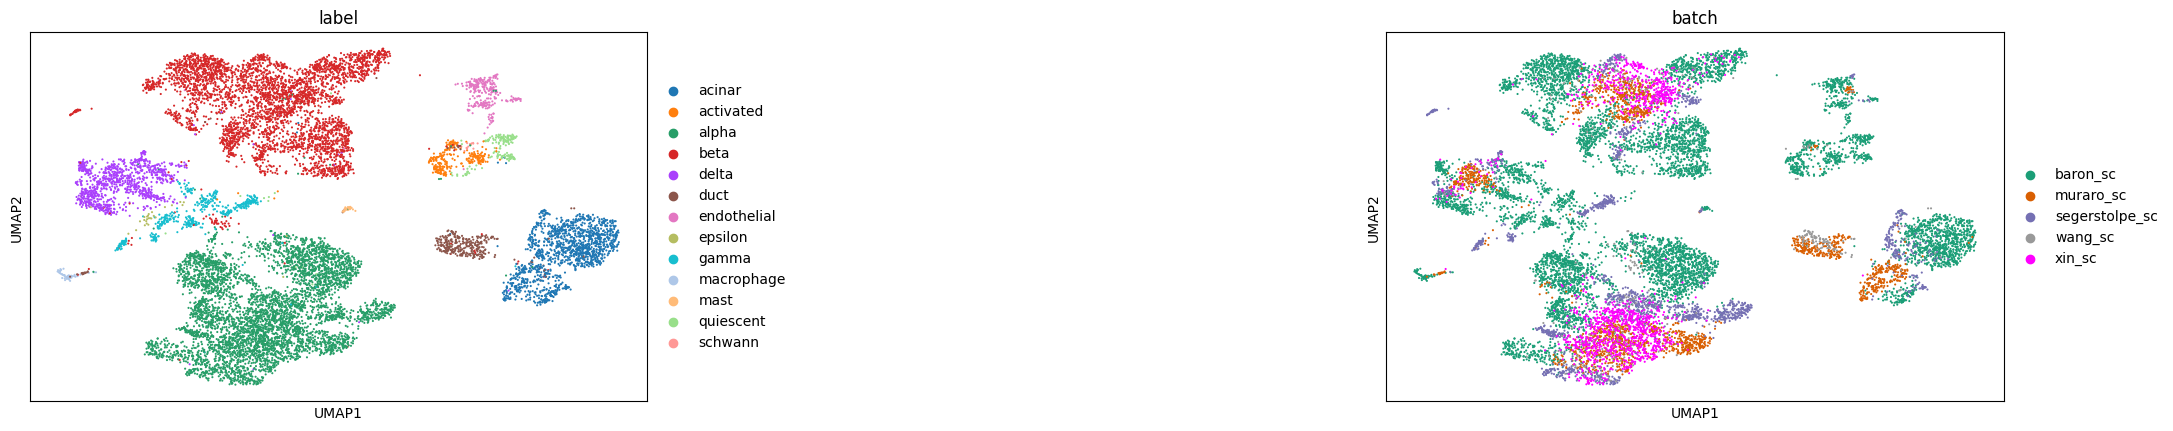

In [ ]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=1)


In [ ]:
sc.pp.neighbors(adata_scanvi, use_rep='X_scANVI', key_added = "scanvi_nn")

true = adata.obs["label"]
best = (0,0,0,0)
for res in np.arange(0.1, 3.01, 0.1):
    sc.tl.louvain(adata_scanvi, obsp='scanvi_nn_distances', resolution = res, key_added = "louvain_scanvi_"+str(res))
    pred = adata_scanvi.obs['louvain_scanvi_'+str(res)]
    nmi = normalized_mutual_info_score(pred, true, average_method="arithmetic")
    label_ari = adjusted_rand_score(pred, y_)
    batch_ari = adjusted_rand_score(pred, b_)
    if best[1] < nmi:
        best = (res, nmi, batch_ari, label_ari)
print(best)

(0.1, 0.8733531457859234, -0.019799213315938195, 0.9367992377003943)


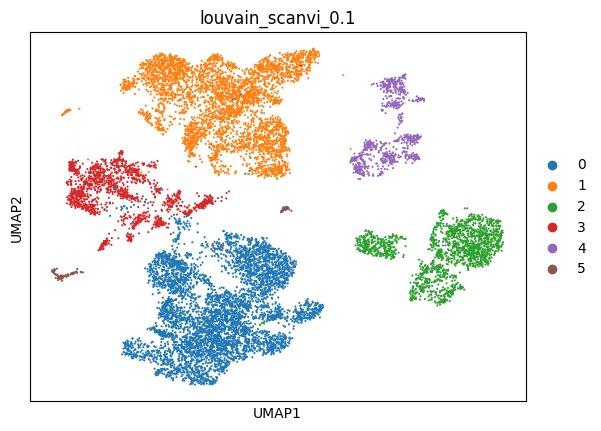

In [ ]:
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=['louvain_scanvi_0.1'])

## BBKNN

In [ ]:
!pip install --quiet bbknn

In [ ]:
import bbknn
adata_bbknn = adata.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=3
)
adata_bbknn


AnnData object with n_obs × n_vars = 12927 × 15590
    obs: 'label', 'batch'
    var: 'n_cells'
    uns: 'batch_colors', 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

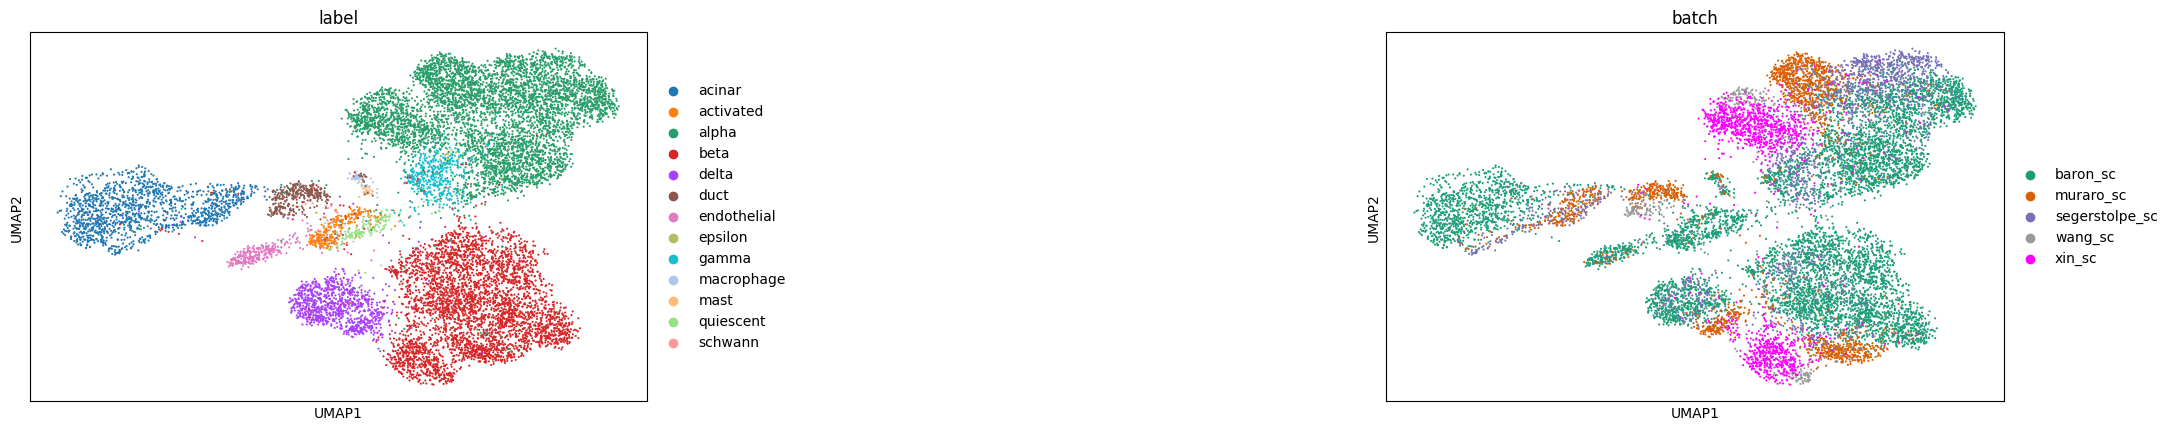

In [ ]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], wspace=1)
